Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.4).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!
/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


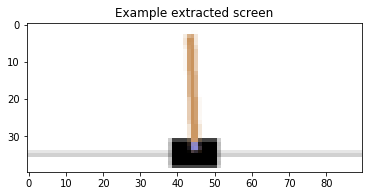

Streaming output truncated to the last 5000 lines.
train episode = 49
train episode = 50
train episode = 51
train episode = 52
train episode = 53
train episode = 54
train episode = 55
train episode = 56
train episode = 57
train episode = 58
train episode = 59
train episode = 60
train episode = 61
train episode = 62
train episode = 63
train episode = 64
train episode = 65
train episode = 66
train episode = 67
train episode = 68
train episode = 69
train episode = 70
train episode = 71
train episode = 72
train episode = 73
train episode = 74
train episode = 75
train episode = 76
train episode = 77
train episode = 78
train episode = 79
train episode = 80
train episode = 81
train episode = 82
train episode = 83
train episode = 84
train episode = 85
train episode = 86
train episode = 87
train episode = 88
train ***t=118***
train episode = 89
train ***t=113***
train episode = 90
train episode = 91
train episode = 92
train episode = 93
train episode = 94
train episode = 95
train episode = 96
t

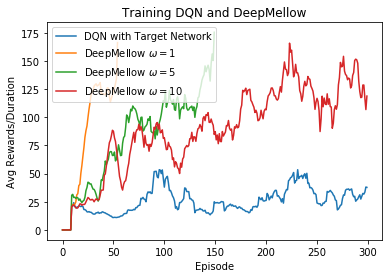

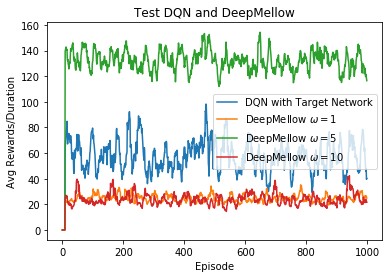

In [2]:
#Reference: https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
    
### Comment if you are running locally
### For Collab
!pip install gym
!apt-get install python-opengl -y
!apt install xvfb -y

!pip install gym[CartPole]

!pip install pyvirtualdisplay
!pip install piglet

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()
###

import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import copy
from collections import namedtuple
from itertools import count
from PIL import Image
from IPython.display import Latex

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200

###### Init
env = gym.make('CartPole-v0').unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

class DQN(nn.Module):
        def __init__(self, h, w, outputs):
            super(DQN, self).__init__()
            self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
            self.bn1 = nn.BatchNorm2d(16)
            self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
            self.bn2 = nn.BatchNorm2d(32)
            self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
            self.bn3 = nn.BatchNorm2d(32)

            # Number of Linear input connections depends on output of conv2d layers
            # and therefore the input image size, so compute it.
            def conv2d_size_out(size, kernel_size=5, stride=2):
                return (size - (kernel_size - 1) - 1) // stride + 1

            convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
            convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
            linear_input_size = convw * convh * 32
            self.head = nn.Linear(linear_input_size, outputs)

        # Called with either one element to determine next action, or a batch
        # during optimization. Returns tensor([[left0exp,right0exp]...]).
        def forward(self, x):
            x = F.relu(self.bn1(self.conv1(x)))
            x = F.relu(self.bn2(self.conv2(x)))
            x = F.relu(self.bn3(self.conv3(x)))
            return self.head(x.view(x.size(0), -1))


resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])

def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

def get_screen():
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    # Cart is in the lower half, so strip off the top and bottom of the screen
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0).to(device)

env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

# Get screen size so that we can initialize layers correctly based on shape
# returned from AI gym. Typical dimensions at this point are close to 3x40x90
# which is the result of a clamped and down-scaled render buffer in get_screen()
init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

# Get number of actions from gym action space
n_actions = env.action_space.n

def mmLogExp(x, mm_omega):
    b = torch.max(mm_omega * x)
    expSum = torch.exp(mm_omega * x - b)
    mm = b + torch.log(expSum.sum()) - np.log(x.numel())
    mm = mm / mm_omega

    return mm

def MellowMax(states, mm_omega):
    mellow_max = []

    # print(f'states size={states.size()}, states={states}')
    for s in states:
        mm = mmLogExp(s, mm_omega)
        mellow_max.append(mm)

    # print(f'mellow={mellow_max}')
    return torch.FloatTensor(mellow_max)

def select_action(state, policy_net, steps_done):
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
                    math.exp(-1. * steps_done / EPS_DECAY)

    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            # print(f'state={policy_net(state)}, max state={policy_net(state).max(1)}')
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

def plot_durations(results, fig, title, labels):
    plt.figure(fig)
    plt.clf()
    plt.title(title)
    plt.xlabel('Episode')
    plt.ylabel('Avg Rewards/Duration')

    for i in range(len(results)):
        durations_t = torch.tensor(results[i], dtype=torch.float)

        # Take 10 episode averages and plot them too
        if len(durations_t) >= 10:
            lbl = labels[i]
            means = durations_t.unfold(0, 10, 1).mean(1).view(-1)
            means = torch.cat((torch.zeros(9), means))
            plt.plot(means.numpy(), label=lbl)

    plt.legend()

#     plt.pause(0.001)  # pause a bit so that plots are updated
#     if is_ipython:
#         display.clear_output(wait=True)
#         display.display(plt.gcf())

# def plot_loss():
#     plt.figure(3)
#     plt.clf()
#     loss_t = torch.tensor(loss_hist, dtype=torch.float)
#     plt.title('Loss...')
#     plt.xlabel('Episode')
#     plt.ylabel('Loss')
#     plt.plot(loss_t.numpy(), label="loss")
#
#     plt.legend()

def optimize_model(policy_net, target_net, memory, deep_mellow, mm_omega):
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                       if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # print(f'state_batch={state_batch}, action_batch={action_batch}, reward_batch={reward_batch}')
    # print(f'non_final_next_states.size={non_final_next_states.size()}, non_final_next_states={non_final_next_states}')

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)

    if deep_mellow == False:
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    else:
        s = policy_net(non_final_next_states).detach()
        mm = MellowMax(s, mm_omega)
        next_state_values[non_final_mask] = mm

    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    #loss_hist.append(loss)
    # loss = F.mse_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

    return policy_net

def print_model_params(model):
    for p in model.parameters():
        if p.requires_grad:
            print(p.name, p.data)

def cal_avg_perf(t):
    global past_steps
    if len(past_steps) < AVG_NUM_STEPS:
        past_steps.append(t)
        return -1
    else:
        past_steps = past_steps[1:]
        past_steps.append(t)
        return np.mean(past_steps)

def train(num_episodes, _policy_net, target_net, memory, target_update, deep_mellow, mm_omega):
    policy_net = _policy_net
    best_policy_net = _policy_net
    episode_durations = []
    steps_done = 0
    max_avg = -1
    train_done = False
    
    for i_episode in range(num_episodes):
        if train_done == True:
            break;
            
        # Initialize the environment and state
        env.reset()
        last_screen = get_screen()
        current_screen = get_screen()
        state = current_screen - last_screen
        for t in count():
            # Select and perform an action
            steps_done += 1
            action = select_action(state, policy_net, steps_done)
            _, reward, done, _ = env.step(action.item())
            reward = torch.tensor([reward], device=device)

            # Observe new state
            last_screen = current_screen
            current_screen = get_screen()
            if not done:
                next_state = current_screen - last_screen
            else:
                next_state = None

            # Store the transition in memory
            memory.push(state, action, next_state, reward)

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the target network)
            opt_policy_net = optimize_model(policy_net, target_net, memory, deep_mellow, mm_omega)
            if opt_policy_net != None:
                policy_net = opt_policy_net

            if done:
                # print(f't={t}')
                if t > 100:
                    print(f'train ***t={t}***')
                episode_durations.append(t + 1)
                #plot_durations(episode_durations)
                #plot_loss()
                avg = cal_avg_perf(t)
                if avg > max_avg:
                    best_policy_net = copy.deepcopy(policy_net)
                    max_avg = avg
                if avg > MAX_REWARDS:
                    train_done = True
                break

        # Update the target network, copying all weights and biases in DQN
        if i_episode % target_update == 0:
            target_net.load_state_dict(policy_net.state_dict())

        print(f'train episode = {i_episode}')

    # print(f'+++best_policy')
    # print_model_params(best_policy_net)
    # print(f'---best_policy')
    print(f'Training Complete. Max Avg={max_avg}')
    env.render()
    env.close()
    # plt.ioff()
    # plt.show()
    return episode_durations, best_policy_net

def select_eval_action(state, policy_net):
    with torch.no_grad():
        # t.max(1) will return largest column value of each row.
        # second column on max result is index of where max element was
        # found, so we pick action with the larger expected reward.
        # print(f'state={policy_net(state)}, max state={policy_net(state).max(1)[1].view(1, 1)}')
        return policy_net(state).max(1)[1].view(1, 1)

def test(num_episodes, policy_net):
    episode_durations = []

    # Set the policy net in eval mode
    policy_net.eval()
    for i_episode in range(num_episodes):
        # Initialize the environment and state
        env.reset()
        last_screen = get_screen()
        current_screen = get_screen()
        state = current_screen - last_screen
        for t in count():
            # Select and perform an action
            action = select_eval_action(state, policy_net)
            _, reward, done, _ = env.step(action.item())
            reward = torch.tensor([reward], device=device)

            # Observe new state
            last_screen = current_screen
            current_screen = get_screen()
            if not done:
                next_state = current_screen - last_screen
            else:
                next_state = None

            # Move to the next state
            state = next_state

            if done:
                print(f'Test t={t}')
                episode_durations.append(t + 1)
                #plot_durations(episode_durations)
                break

    print('Complete')
    env.render()
    env.close()
    plt.ioff()
    plt.show()

    return episode_durations

# main code
train_results = []
results = []
labels = []
NUM_TRAIN_EPISODES = 300
NUM_TEST_EPISODES = 1000
AVG_NUM_STEPS = 5
MAX_REWARDS = 200
past_steps = []


# DQN with Target Network
print("DQN with Target Network")
policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)
labels.append("DQN with Target Network")

train_eps_dur, policy_net = train(NUM_TRAIN_EPISODES, policy_net, target_net, memory, target_update=10, deep_mellow=False, mm_omega=0)
eps_dur = test(NUM_TEST_EPISODES, policy_net)
train_results.append(train_eps_dur)
results.append(eps_dur)

# # DQN without Target Network
# print("DQN without Target Network")
# policy_net = DQN(screen_height, screen_width, n_actions).to(device)
# target_net = DQN(screen_height, screen_width, n_actions).to(device)
# target_net.load_state_dict(policy_net.state_dict())
# target_net.eval()
# optimizer = optim.RMSprop(policy_net.parameters())
# memory = ReplayMemory(10000)
# labels.append("DQN without Target Network")
# past_steps = []

# train_eps_dur, policy_net = train(NUM_TRAIN_EPISODES, policy_net, target_net, memory, target_update=1, deep_mellow=False, mm_omega=0)
# eps_dur = test(NUM_TEST_EPISODES, policy_net)
# train_results.append(train_eps_dur)
# results.append(eps_dur)

# # DQN with Target Update=5
# print("DQN with Target Update=5")
# policy_net = DQN(screen_height, screen_width, n_actions).to(device)
# target_net = DQN(screen_height, screen_width, n_actions).to(device)
# target_net.load_state_dict(policy_net.state_dict())
# target_net.eval()
# optimizer = optim.RMSprop(policy_net.parameters())
# memory = ReplayMemory(10000)
# labels.append("DQN with Target Update=5")
# past_steps = []

# train_eps_dur, policy_net = train(NUM_TRAIN_EPISODES, policy_net, target_net, memory, target_update=5, deep_mellow=False, mm_omega=0)
# eps_dur = test(NUM_TEST_EPISODES, policy_net)
# train_results.append(train_eps_dur)
# results.append(eps_dur)


# # DQN with Target Update=25
# print("DQN with Target Update=25")
# policy_net = DQN(screen_height, screen_width, n_actions).to(device)
# target_net = DQN(screen_height, screen_width, n_actions).to(device)
# target_net.load_state_dict(policy_net.state_dict())
# target_net.eval()
# optimizer = optim.RMSprop(policy_net.parameters())
# memory = ReplayMemory(10000)
# labels.append("DQN with Target Update=25")
# past_steps = []

# train_eps_dur, policy_net = train(NUM_TRAIN_EPISODES, policy_net, target_net, memory, target_update=25, deep_mellow=False, mm_omega=0)
# eps_dur = test(NUM_TEST_EPISODES, policy_net)
# train_results.append(train_eps_dur)
# results.append(eps_dur)


# DeepMellow (omega=1)
print("DeepMellow w=1")
policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)
labels.append("DeepMellow $\omega=1$")
past_steps = []

train_eps_dur, policy_net = train(NUM_TRAIN_EPISODES, policy_net, target_net, memory, target_update=10, deep_mellow=True, mm_omega=1)
eps_dur = test(NUM_TEST_EPISODES, policy_net)
train_results.append(train_eps_dur)
results.append(eps_dur)

# DeepMellow (omega=5)
print("DeepMellow omega=5")
policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)
labels.append("DeepMellow $\omega=5$")
past_steps = []

train_eps_dur, policy_net = train(NUM_TRAIN_EPISODES, policy_net, target_net, memory, target_update=10, deep_mellow=True, mm_omega=5)
eps_dur = test(NUM_TEST_EPISODES, policy_net)
train_results.append(train_eps_dur)
results.append(eps_dur)

# DeepMellow (omega=10)
print("DeepMellow omega=10")
policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)
labels.append("DeepMellow $\omega=10$")
past_steps = []

train_eps_dur, policy_net = train(NUM_TRAIN_EPISODES, policy_net, target_net, memory, target_update=10, deep_mellow=True, mm_omega=10)
eps_dur = test(NUM_TEST_EPISODES, policy_net)
train_results.append(train_eps_dur)
results.append(eps_dur)

# # DeepMellow (omega=100)
# print("DeepMellow omega=100")
# policy_net = DQN(screen_height, screen_width, n_actions).to(device)
# target_net = DQN(screen_height, screen_width, n_actions).to(device)
# target_net.load_state_dict(policy_net.state_dict())
# target_net.eval()
# optimizer = optim.RMSprop(policy_net.parameters())
# memory = ReplayMemory(10000)
# labels.append("DeepMellow $\omega=100$")
#
# train_eps_dur, policy_net = train(NUM_TRAIN_EPISODES, policy_net, target_net, memory, target_update=10, deep_mellow=True, mm_omega=100)
# eps_dur = test(NUM_TEST_EPISODES, policy_net)
# results.append(eps_dur)


plot_durations(train_results, 2, 'Training DQN and DeepMellow', labels)
plot_durations(results, 3, 'Test DQN and DeepMellow', labels)

plt.show()